In [17]:
#pip install matplotlib
import json
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon, Rectangle

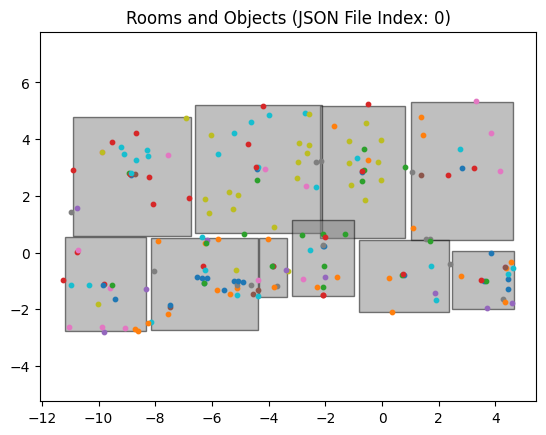

In [20]:
class RoomDataProcessor:
    def __init__(self, json_dir, id_list_file):
        self.json_dir = json_dir
        self.id_list_file = id_list_file
        self.data_list = []

    def load_json_files(self):
        with open(self.id_list_file, 'r') as f:
            ids = f.read().splitlines()

        for file_id in ids:
            file_path = os.path.join(self.json_dir, f"{file_id}.json")
            with open(file_path, 'r') as f:
                json_data = json.load(f)
                data = self.process_json_data(json_data)
                self.data_list.append(data)

    def process_json_data(self, json_data):
        building_position = json_data.get('building_position', [1, 1, 1])

        room_positions = []
        object_positions = []
        building_positions = [building_position[:2]]  # 假设建筑物的位置为二维坐标
        room_labels = []
        object_labels = []
        building_labels = [0]  # 假设建筑物标签统一为 0
        room_edge_index = []
        object_edge_index = []
        building_edge_index = []
        room_bboxes = []  # 仅为 rooms 提取 bbox

        rooms = json_data['rooms']
        
        # 处理 rooms
        for room_index, room in enumerate(rooms):
            room_pos = [room['position'][0] / max(building_position[0], 1e-6), 
                        room['position'][1] / max(building_position[1], 1e-6)]
            room_positions.append(room_pos)
            room_labels.append(room['region_index'])  # 使用 region_index 作为房间的标签

            # 提取 room 的 bbox 数据
            room_bboxes.append(room['bbox'])

            # 处理 objects 数据
            if 'objects' in room:
                for obj in room['objects']:
                    obj_pos = [obj['position'][0] / max(building_position[0], 1e-6), 
                               obj['position'][1] / max(building_position[1], 1e-6)]
                    object_positions.append(obj_pos)
                    object_labels.append(obj['category_index'])  # 使用 category_index 作为对象的标签

                    object_index = len(object_positions) - 1

                    # Room 与 Object 之间的边
                    room_edge_index.append([room_index, object_index])
                    room_edge_index.append([object_index, room_index])

        # 房间与建筑物之间的连接
        building_index = 0  # 假设只有一个建筑物，索引为 0
        for room_index in range(len(room_positions)):
            building_edge_index.append([room_index, building_index])
            building_edge_index.append([building_index, room_index])

        # 构建 x 特征矩阵
        room_positions_tensor = torch.tensor(room_positions, dtype=torch.float)
        object_positions_tensor = torch.tensor(object_positions, dtype=torch.float)
        building_positions_tensor = torch.tensor(building_positions, dtype=torch.float)

        x = {
            'room_x': room_positions_tensor,
            'object_x': object_positions_tensor,
            'building_x': building_positions_tensor
        }

        # 将 edge_index 分开存储
        room_edge_index = torch.tensor(room_edge_index, dtype=torch.long).t().contiguous()
        object_edge_index = torch.tensor(object_edge_index, dtype=torch.long).t().contiguous()
        building_edge_index = torch.tensor(building_edge_index, dtype=torch.long).t().contiguous()

        # 将不同层级的标签存储为 y 的不同部分
        y = {
            'room_labels': torch.tensor(room_labels, dtype=torch.long),
            'object_labels': torch.tensor(object_labels, dtype=torch.long),
            'building_labels': torch.tensor(building_labels, dtype=torch.long)
        }
        
        # 构建 Data 对象并返回
        data = Data(x=x, y=y, room_edge_index=room_edge_index, object_edge_index=object_edge_index, building_edge_index=building_edge_index, bbox=room_bboxes)
        data.num_nodes = sum(len(v) for v in x.values())
        return data
        
    def create_dataloader(self, batch_size=1):
        return DataLoader([(data, objects) for data, _, objects in self.data_list], batch_size=batch_size, shuffle=True)

    def draw_rooms_and_objects(self, index=0):
        if index < len(self.data_list):
            data = self.data_list[index]
            
            # 分别获取 rooms, objects, 和 building 的 position
            room_x = data.x['room_x']
            object_x = data.x['object_x']
            building_x = data.x['building_x']
            
            room_labels = data.y['room_labels']
            object_labels = data.y['object_labels']
            building_labels = data.y['building_labels']
    
            plt.figure()
    
            # 绘制房间，使用 bbox 数据来计算中心和尺寸
            for i, bbox in enumerate(data.bbox):  # 访问存储的 bbox 数据
                if isinstance(bbox, torch.Tensor):
                    bbox = bbox.tolist()
                xlo, ylo, zlo, xhi, yhi, zhi = bbox  # 将 tensor 或列表转换为标准列表
                width = xhi - xlo
                height = yhi - ylo
    
                # 计算房间的中心位置
                center_x = (xhi + xlo) / 2.0
                center_y = (yhi + ylo) / 2.0
    
                # 使用房间的中心位置和尺寸绘制矩形
                plt.gca().add_patch(Rectangle(
                    (center_x - width / 2, center_y - height / 2), width, height, edgecolor='black', facecolor='gray', alpha=0.5))
    
            # 为不同类别的物体分配不同的颜色
            category_colors = list(mcolors.TABLEAU_COLORS.values())
            num_categories = len(category_colors)
    
            # 绘制 objects 的位置
            for i, obj_pos in enumerate(object_x):
                color = category_colors[object_labels[i] % num_categories]
                plt.scatter(obj_pos[0], obj_pos[1], c=color, s=10)
    
            # 绘制建筑物的位置（如果有需要）
            for i, building_pos in enumerate(building_x):
                plt.scatter(building_pos[0], building_pos[1], c='red', s=50, marker='x')
    
            plt.axis('equal')
            plt.title(f'Rooms and Objects (JSON File Index: {index})')
            plt.show()
        else:
            print("Index out of range. Please select a valid index.")
    
if __name__ == "__main__":
    json_dir = '../output'
    id_list_file = 'ID.txt'

    processor = RoomDataProcessor(json_dir, id_list_file)
    processor.load_json_files()
    processor.draw_rooms_and_objects(index=0)


In [24]:
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader

def split_data(data_list, test_size=0.2):
    train_data, test_data = train_test_split(data_list, test_size=test_size, random_state=42)
    return train_data, test_data


In [25]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class SimpleGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [26]:
def train(model, train_loader, optimizer, target_type='room'):
    model.train()
    for data in train_loader:  # 遍历每个批次的数据
        optimizer.zero_grad()  # 清空梯度
        
        out = model(data)  # 前向传播
        
        if target_type == 'room':
            loss = F.nll_loss(out[:len(data.y['room_labels'])], data.y['room_labels'])  # 计算房间的损失
        elif target_type == 'object':
            loss = F.nll_loss(out[len(data.y['room_labels']):], data.y['object_labels'])  # 计算对象的损失
        
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数

def test(model, loader, target_type='room'):
    model.eval()
    correct = 0
    total = 0
    for data in loader:  # 测试集数据
        out = model(data)  # 前向传播
        
        if target_type == 'room':
            pred = out[:len(data.y['room_labels'])].argmax(dim=1)  # 预测房间的类别
            correct += (pred == data.y['room_labels']).sum().item()
            total += len(data.y['room_labels'])
        elif target_type == 'object':
            pred = out[len(data.y['room_labels']):].argmax(dim=1)  # 预测对象的类别
            correct += (pred == data.y['object_labels']).sum().item()
            total += len(data.y['object_labels'])
    
    return correct / total  # 返回准确率


In [27]:
if __name__ == "__main__":
    json_dir = '../output'
    id_list_file = 'ID.txt'

    processor = RoomDataProcessor(json_dir, id_list_file)
    processor.load_json_files()

    # 数据集划分
    train_data, test_data = split_data(processor.data_list)
    train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=4, shuffle=False)

    # 定义模型
    in_channels = train_loader.dataset[0].x.shape[1]  # 输入特征数
    hidden_channels = 16  # 隐藏层大小
    out_channels = max(train_loader.dataset[0].y['room_labels'].max().item(),
                       train_loader.dataset[0].y['object_labels'].max().item()) + 1  # 输出类别数

    model = SimpleGCN(in_channels, hidden_channels, out_channels)

    # 定义优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # 训练和测试模型
    for epoch in range(50):  # 训练50个epoch
        train(model, train_loader, optimizer, target_type='room')
        train_acc = test(model, train_loader, target_type='room')  # 在训练集上测试
        test_acc = test(model, test_loader, target_type='room')  # 在测试集上测试
        print(f'Epoch: {epoch+1}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 1, Train Acc: 0.0346, Test Acc: 0.0380
Epoch: 2, Train Acc: 0.0364, Test Acc: 0.0359
Epoch: 3, Train Acc: 0.0381, Test Acc: 0.0380
Epoch: 4, Train Acc: 0.0410, Test Acc: 0.0401
Epoch: 5, Train Acc: 0.0358, Test Acc: 0.0422
Epoch: 6, Train Acc: 0.0370, Test Acc: 0.0359
Epoch: 7, Train Acc: 0.0433, Test Acc: 0.0316
Epoch: 8, Train Acc: 0.0364, Test Acc: 0.0422
Epoch: 9, Train Acc: 0.0421, Test Acc: 0.0380
Epoch: 10, Train Acc: 0.0421, Test Acc: 0.0380
Epoch: 11, Train Acc: 0.0381, Test Acc: 0.0338
Epoch: 12, Train Acc: 0.0410, Test Acc: 0.0380
Epoch: 13, Train Acc: 0.0433, Test Acc: 0.0295
Epoch: 14, Train Acc: 0.0421, Test Acc: 0.0316
Epoch: 15, Train Acc: 0.0375, Test Acc: 0.0295
Epoch: 16, Train Acc: 0.0341, Test Acc: 0.0295
Epoch: 17, Train Acc: 0.0375, Test Acc: 0.0401
Epoch: 18, Train Acc: 0.0352, Test Acc: 0.0401
Epoch: 19, Train Acc: 0.0410, Test Acc: 0.0232
Epoch: 20, Train Acc: 0.0421, Test Acc: 0.0380
Epoch: 21, Train Acc: 0.0381, Test Acc: 0.0316
Epoch: 22, Train Acc: 

In [3]:
'''
class RoomDataProcessor:
    def __init__(self, json_dir, id_list_file):
        self.json_dir = json_dir
        self.id_list_file = id_list_file
        self.data_list = []

    def load_json_files(self):
        with open(self.id_list_file, 'r') as f:
            ids = f.read().splitlines()

        for file_id in ids:
            file_path = os.path.join(self.json_dir, f"{file_id}.json")
            with open(file_path, 'r') as f:
                json_data = json.load(f)
                data = self.process_json_data(json_data)
                self.data_list.append(data)

    def process_json_data(self, json_data):
        building_position = json_data.get('building_position', [1, 1, 1])

        positions = []  # 用于存储 rooms 中的 position 数据
        labels = []
        bboxes = []  # 用于存储 bbox 数据
        objects = []

        rooms = json_data['rooms']
        
        for room in rooms:
            # 提取 room 的 position 数据
            position = [room['position'][0] / max(building_position[0], 1e-6), 
                        room['position'][1] / max(building_position[1], 1e-6)]
            positions.append(position)

            # 提取 room 的 bbox 数据
            xlo, ylo, zlo, xhi, yhi, zhi = room['bbox']
            bboxes.append([xlo, ylo, zlo, xhi, yhi, zhi])

            labels.append(room['region_index'])

            # 处理 objects 数据
            if 'objects' in room:
                for obj in room['objects']:
                    obj_pos = [obj['position'][0] / max(building_position[0], 1e-6), 
                               obj['position'][1] / max(building_position[1], 1e-6)]
                    a0 = obj['axis_directions(a0)'][:2]
                    a1 = obj['axis_directions(a1)'][:2]
                    radii = obj['radii(r)']

                    category_index = obj['category_index']
                    if category_index == -1:
                        continue
                    
                    objects.append((obj_pos, a0, a1, radii, category_index))

        # 将 positions, labels, bboxes 转换为 tensor
        x = torch.tensor(positions, dtype=torch.float)
        y = torch.tensor(labels, dtype=torch.long)
        bboxes = torch.tensor(bboxes, dtype=torch.float)

        # 返回 Data 对象，其中 x 存储 position，bboxes 存储 bbox 数据
        return Data(x=x, y=y, bbox=bboxes), objects

        
    def create_dataloader(self, batch_size=1):
        return DataLoader([(data, objects) for data, _, objects in self.data_list], batch_size=batch_size, shuffle=True)

    def draw_rooms_and_objects(self, index=0):
        if index < len(self.data_list):
            data, objects = self.data_list[index]
            plt.figure()
    
            # 绘制房间，使用 position 数据
            for i, pos in enumerate(data.x):  # 访问存储的 position 数据
                bbox = data.bbox[i].tolist()  # 获取对应的 bbox 数据
                xlo, ylo, zlo, xhi, yhi, zhi = bbox
                width = xhi - xlo
                height = yhi - ylo
    
                # 使用房间的 position 值和尺寸绘制矩形
                plt.gca().add_patch(plt.Rectangle(
                    (pos[0] - width / 2, pos[1] - height / 2), width, height, edgecolor='blue', facecolor='gray', alpha=0.5))
    
            # 为不同类别的物体分配不同的颜色
            category_colors = list(mcolors.TABLEAU_COLORS.values())
            num_categories = len(category_colors)
    
            # 绘制 objects as oriented bounding boxes (OBBs)
            for obj_pos, a0, a1, radii, category_index in objects:
                p0 = np.array(obj_pos) - radii[0] * np.array(a0) - radii[1] * np.array(a1)
                p1 = np.array(obj_pos) + radii[0] * np.array(a0) - radii[1] * np.array(a1)
                p2 = np.array(obj_pos) + radii[0] * np.array(a0) + radii[1] * np.array(a1)
                p3 = np.array(obj_pos) - radii[0] * np.array(a0) + radii[1] * np.array(a1)
                
                color = category_colors[category_index % num_categories]
    
                polygon = Polygon([p0, p1, p2, p3], edgecolor=color, facecolor='none', linewidth=2, alpha=0.8)
                plt.gca().add_patch(polygon)
                plt.scatter(obj_pos[0], obj_pos[1], c=color, s=10)
            
            plt.axis('equal')
            plt.title(f'Rooms and Objects (JSON File Index: {index})')
            plt.show()
        else:
            print("Index out of range. Please select a valid index.")


    
if __name__ == "__main__":
    json_dir = '../output'
    id_list_file = 'ID.txt'

    processor = RoomDataProcessor(json_dir, id_list_file)
    processor.load_json_files()
    processor.draw_rooms_and_objects(index=0)
'''

'\nclass RoomDataProcessor:\n    def __init__(self, json_dir, id_list_file):\n        self.json_dir = json_dir\n        self.id_list_file = id_list_file\n        self.data_list = []\n\n    def load_json_files(self):\n        with open(self.id_list_file, \'r\') as f:\n            ids = f.read().splitlines()\n\n        for file_id in ids:\n            file_path = os.path.join(self.json_dir, f"{file_id}.json")\n            with open(file_path, \'r\') as f:\n                json_data = json.load(f)\n                data = self.process_json_data(json_data)\n                self.data_list.append(data)\n\n    def process_json_data(self, json_data):\n        building_position = json_data.get(\'building_position\', [1, 1, 1])\n\n        positions = []  # 用于存储 rooms 中的 position 数据\n        labels = []\n        bboxes = []  # 用于存储 bbox 数据\n        objects = []\n\n        rooms = json_data[\'rooms\']\n        \n        for room in rooms:\n            # 提取 room 的 position 数据\n            position =

ValueError: not enough values to unpack (expected 5, got 2)

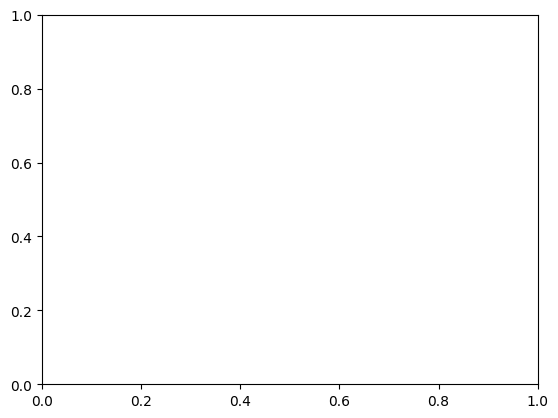

In [4]:
processor.draw_rooms_and_objects(index=0)

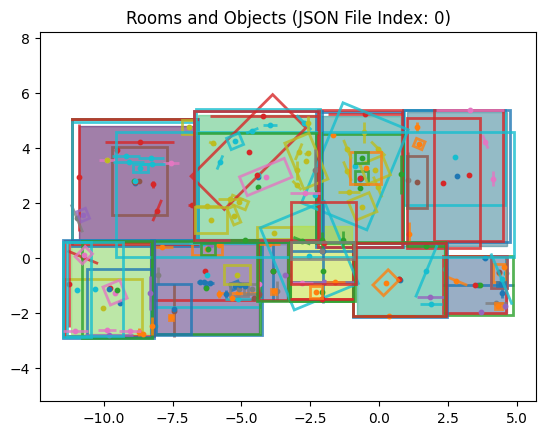

In [49]:
import json
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon  # 导入 Polygon 用于绘制旋转矩形

class RoomDataProcessor:
    def __init__(self, json_dir, id_list_file):
        self.json_dir = json_dir
        self.id_list_file = id_list_file
        self.data_list = []

    def load_ids(self):
        with open(self.id_list_file, 'r') as f:
            self.ids = f.read().splitlines()

    def load_json_files(self):
        self.load_ids()
        for id in self.ids:
            file_path = os.path.join(self.json_dir, f"{id}.json")
            with open(file_path, 'r') as f:
                json_data = json.load(f)
                data = self.process_json_data(json_data)
                self.data_list.append(data)

    def process_json_data(self, json_data):
        building_position = json_data.get('building_position', [1, 1, 1])

        node_features = []
        edge_index = []
        bboxes = []
        objects = []
        
        rooms = json_data['rooms']
        
        for room_index, room in enumerate(rooms):
            # 提取 room 的 bbox 数据，并进行归一化计算
            xlo, ylo, zlo, xhi, yhi, zhi = room['bbox']
            width = xhi - xlo
            height = yhi - ylo

            room_position = [xlo / max(building_position[0], 1e-6), 
                             ylo / max(building_position[1], 1e-6)]
            node_features.append(room_position)
            bboxes.append((room_position, width / max(building_position[0], 1e-6), 
                           height / max(building_position[1], 1e-6)))
            
            # 处理 objects 数据
            if 'objects' in room:
                for obj in room['objects']:
                    obj_pos = [obj['position'][0] / max(building_position[0], 1e-6), 
                               obj['position'][1] / max(building_position[1], 1e-6)]
                    a0 = obj['axis_directions(a0)'][:2]  # 只取 a0 的前两个分量
                    a1 = obj['axis_directions(a1)'][:2]  # 只取 a1 的前两个分量
                    radii = obj['radii(r)']

                    objects.append((obj_pos, a0, a1, radii, obj['category_index']))

        # 构建 edge_index 以表示 objects 之间的关系（基于 category_index）
        if objects:
            for i, obj1 in enumerate(objects):
                for j, obj2 in enumerate(objects):
                    if i != j and obj1[-1] == obj2[-1]:  # 如果两个 object 属于同一类别
                        edge_index.append([i, j])

        x = torch.tensor([obj[0] for obj in objects], dtype=torch.float)
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

        y = None

        return Data(x=x, edge_index=edge_index, y=y), bboxes, objects

    def create_dataloader(self, batch_size=1):
        return DataLoader([data for data, _, _ in self.data_list], batch_size=batch_size, shuffle=True)

    def draw_rooms_and_objects(self, index=0):
        if index < len(self.data_list):
            data, bboxes, objects = self.data_list[index]
            plt.figure()

            # 绘制房间
            for i, (pos, width, height) in enumerate(bboxes):
                color = plt.cm.viridis(i / len(bboxes))
                plt.gca().add_patch(plt.Rectangle((pos[0], pos[1]), 
                                                  width, height, edgecolor=color, facecolor=color, alpha=0.5))

            # 为不同类别的物体分配不同的颜色
            category_colors = list(mcolors.TABLEAU_COLORS.values())  # 使用Matplotlib的颜色表
            num_categories = len(category_colors)
            
            # 绘制 objects as oriented bounding boxes (OBBs)
            for obj_pos, a0, a1, radii, category_index in objects:
                # 计算旋转矩形的四个顶点
                p0 = np.array(obj_pos) - radii[0] * np.array(a0) - radii[1] * np.array(a1)
                p1 = np.array(obj_pos) + radii[0] * np.array(a0) - radii[1] * np.array(a1)
                p2 = np.array(obj_pos) + radii[0] * np.array(a0) + radii[1] * np.array(a1)
                p3 = np.array(obj_pos) - radii[0] * np.array(a0) + radii[1] * np.array(a1)
                
                color = category_colors[category_index % num_categories]  # 分配颜色

                # 使用Polygon绘制旋转矩形
                polygon = Polygon([p0, p1, p2, p3], edgecolor=color, facecolor='none', linewidth=2, alpha=0.8)
                plt.gca().add_patch(polygon)
                plt.scatter(obj_pos[0], obj_pos[1], c=color, s=10)  # 绘制 object 的中心点
            
            plt.axis('equal')
            plt.title(f'Rooms and Objects (JSON File Index: {index})')
            plt.show()
        else:
            print("Index out of range. Please select a valid index.")

# 使用示例
json_dir = '../output'
id_list_file = 'ID.txt'

processor = RoomDataProcessor(json_dir, id_list_file)
processor.load_json_files()

# 绘制第一个JSON文件中房间和objects的位置和大小
processor.draw_rooms_and_objects(index=0)
